KeyboardInterrupt: 

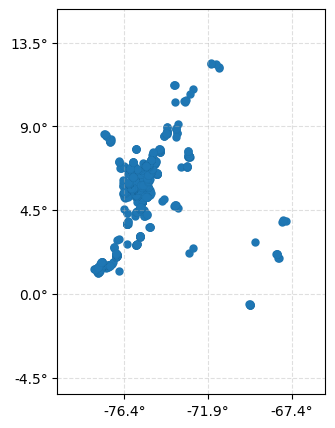

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
# Ruta al archivo shapefile (.shp)
ruta = r"C:/Git_SCA/AGE/Depositos"  # Usa r"" para evitar problemas con backslashes
# Cargar el shapefile
gdf = gpd.read_file(ruta)
# Reproyectar al sistema de Web Mercator (requerido por contextily)
gdf = gdf.to_crs(epsg=3857)
# Función para convertir de Web Mercator a grados decimales (aproximado)
def mercator_to_lon(x, _):
    return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _):
    return f"{y * 180 / 20037508.34:.1f}°"
# Crear el gráfico
fig, ax = plt.subplots(figsize=(5, 5))
# Graficar el shapefile con color según 'Z'
gdf.plot(
    ax=ax,
    linewidth=0.01,
    edgecolor='black'
)
# Centrar el mapa en Colombia (coordenadas en Web Mercator)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])
# Formatear los ejes con coordenadas bonitas
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
# Añadir líneas de grilla suaves
ax.grid(True, which='major', linestyle='--', alpha=0.4)
# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Título y visualización
plt.title("Manifestaciones minerales \n igneo/metamorficas para Colombia \n")
#ax.set_axis_off()  # Si prefieres mostrar solo el mapa sin ejes, descomenta esta línea
plt.show()

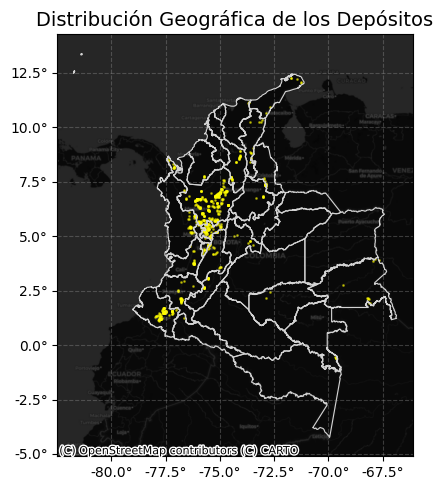

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Reproyectar puntos a EPSG:4326 y extraer coordenadas ===
gdf_latlon = gdf.to_crs(epsg=4326)
gdf['Longitude'] = gdf_latlon.geometry.x
gdf['Latitude'] = gdf_latlon.geometry.y

# === 2. Cargar límites administrativos ===
areas_path = r"C:/Git_SCA/AGE/departamentos"
areas = gpd.read_file(areas_path).to_crs(epsg=4326)

# === 3. Crear figura y eje ===
fig, ax = plt.subplots(figsize=(5, 5))

# === 4. Graficar puntos
ax.scatter(gdf['Longitude'], gdf['Latitude'], s=1, c="xkcd:bright yellow", alpha=0.5)

# === 5. Añadir límites administrativos con color tenue
areas.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8)

# === 6. Mapa base oscuro
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.DarkMatter)

# === 7. Ejes en grados decimales
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}°"))

# === 8. Personalización
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_title("Distribución Geográfica de los Depósitos", fontsize=14)

plt.tight_layout()
plt.show()


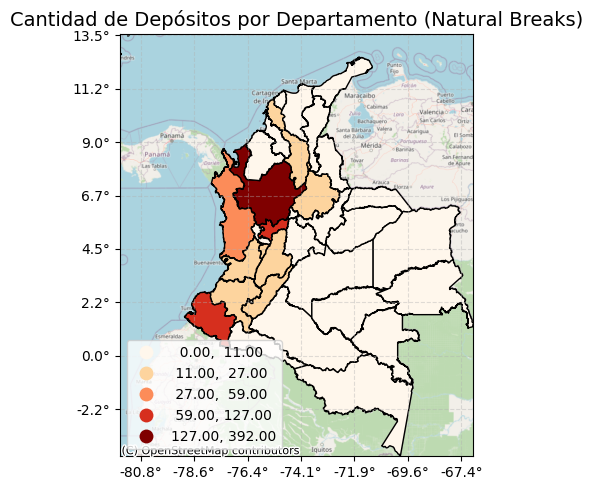

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar puntos y municipios ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=3857)

# === 2. Join espacial: contar puntos por municipio ===
join = gpd.sjoin(gdf, departamentos, predicate='within')
conteo = join.groupby('DeNombre').size().reset_index(name='depositos')

# === 3. Unir conteo al GeoDataFrame de municipios ===
departamentos = departamentos.merge(conteo, on='DeNombre', how='left')
departamentos['depositos'] = departamentos['depositos'].fillna(0)

# === 4. Graficar ===
fig, ax = plt.subplots(figsize=(5, 5))
departamentos.plot(
    column='depositos',
    cmap='OrRd',
    scheme='natural_breaks',
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    edgecolor='black', linestyle="-",
    ax=ax
)

# === 5. Añadir ejes y mapa base ===
minx, miny, maxx, maxy = departamentos.total_bounds
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 180 / 20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y * 180 / 20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

plt.title("Cantidad de Depósitos por Departamento (Natural Breaks)", fontsize=14)
plt.tight_layout()
plt.show()


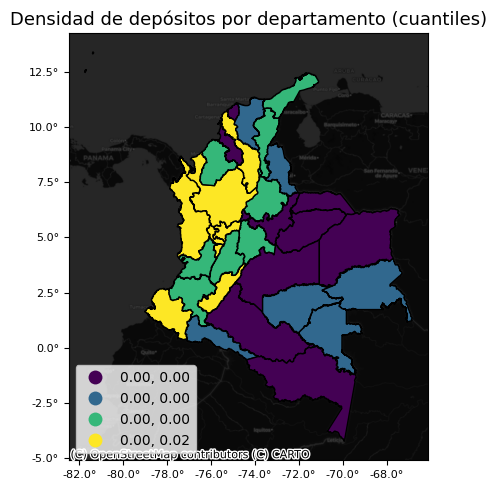

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar shapefiles ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=4326)

# === 2. Spatial join: contar depósitos por departamento ===
joined = gpd.sjoin(gdf, departamentos, predicate='within')
conteo = joined.groupby('DeNombre').size().reset_index(name='conteo_depositos')

# === 3. Calcular densidad: depósitos por área en km² ===
departamentos['area_km2'] = departamentos.geometry.to_crs(epsg=3857).area / 1e6
departamentos = departamentos.merge(conteo, on='DeNombre', how='left')
departamentos['conteo_depositos'] = departamentos['conteo_depositos'].fillna(0)
departamentos['densidad'] = departamentos['conteo_depositos'] / departamentos['area_km2']

# === 4. Mapa choropleth ===
fig, ax = plt.subplots(1, figsize=(5, 5))
departamentos.plot(
    column='densidad',
    scheme='quantiles',
    k=4,
    ax=ax,
    legend=True,
    legend_kwds={"loc": 'lower left'},
    edgecolor='black'
)

# === 5. Formatear ejes con coordenadas en grados ===
def format_lon(x, _): return f"{x:.1f}°"
def format_lat(y, _): return f"{y:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(FuncFormatter(format_lat))
ax.tick_params(axis='both', which='major', labelsize=8)

# === 6. Título y fondo ===
ax.set_title("Densidad de depósitos por departamento (cuantiles)", fontsize=13)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.DarkMatter)

# === 7. Mostrar ===
plt.tight_layout()
plt.show()


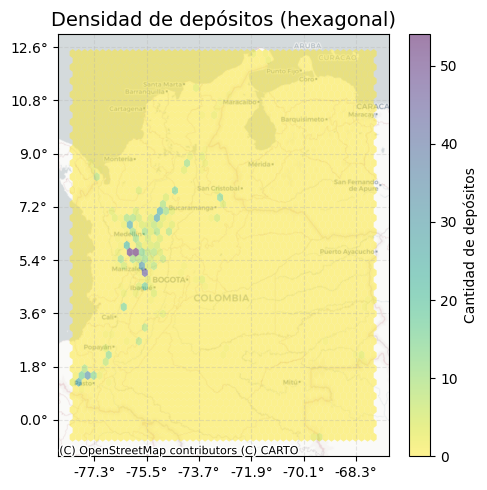

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar depósitos y reproyectar a EPSG:3857 ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# === 2. Crear figura ===
fig, ax = plt.subplots(1, figsize=(5, 5))

# === 3. Hexbin ===
hb = ax.hexbin(
    gdf['x'], gdf['y'],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap='viridis_r'
)

# === 4. Añadir mapa base ===
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)

# === 5. Coordenadas en grados decimales (EPSG:4326) ===
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.3)

# === 6. Leyenda y título ===
plt.colorbar(hb, ax=ax, label='Cantidad de depósitos')
ax.set_title("Densidad de depósitos (hexagonal)", fontsize=14)
plt.tight_layout()
plt.show()


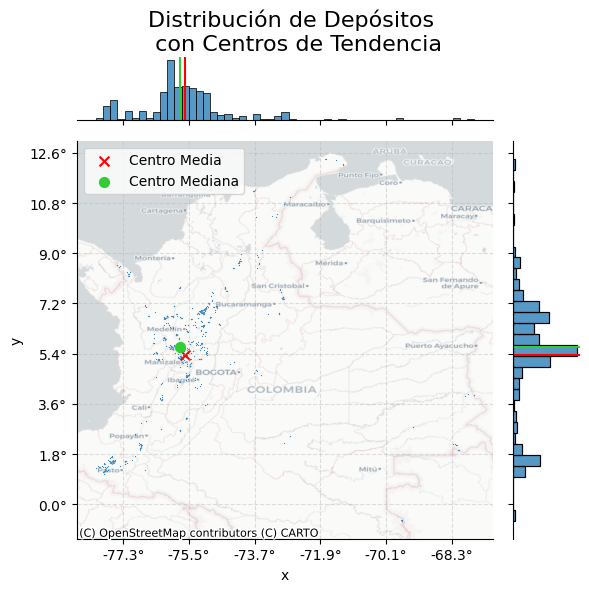

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import numpy as np
from matplotlib.ticker import FuncFormatter

# === 1. Cargar y reproyectar ===
gdf = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# === 2. Calcular centros ===
mean_center = (gdf['x'].mean(), gdf['y'].mean())
med_center = (gdf['x'].median(), gdf['y'].median())

# === 3. Crear jointplot ===
joint_axes = sns.jointplot(x='x', y='y', data=gdf, s=0.75, height=6)

# === 4. Añadir media y mediana ===
joint_axes.ax_joint.scatter(*mean_center, color='red', marker='x', s=50, label='Centro Media')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

joint_axes.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Centro Mediana')
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')

# === 5. Leyenda ===
joint_axes.ax_joint.legend()

# === 6. Añadir mapa base ===
ctx.add_basemap(joint_axes.ax_joint, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)

# === 7. Añadir coordenadas en grados ===
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
joint_axes.ax_joint.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
joint_axes.ax_joint.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
joint_axes.ax_joint.grid(True, linestyle="--", alpha=0.4)

# === 8. Título y ajustes ===
joint_axes.fig.suptitle("Distribución de Depósitos \n con Centros de Tendencia", fontsize=16)
joint_axes.fig.tight_layout()
joint_axes.fig.subplots_adjust(top=0.90)

plt.show()


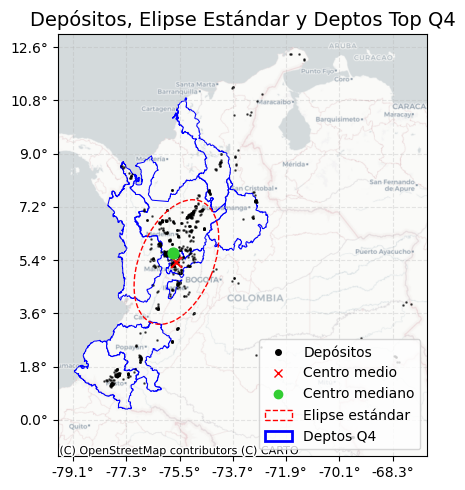

C:\TEMP\ipykernel_16192\4127414463.py:89: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right')


<Figure size 640x480 with 0 Axes>

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1. Cargar datos
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=3857)

# 2. Extraer coordenadas y contar depósitos por departamento
gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y
joined = gpd.sjoin(gdf, departamentos, predicate='within')
counts = joined.groupby('DeNombre').size().reset_index(name='count')
departamentos = departamentos.merge(counts, on='DeNombre', how='left').fillna({'count': 0})

# Filtrar departamentos Q4
q4 = departamentos['count'].quantile(0.75)
top_depts = departamentos[departamentos['count'] > q4]

# 3. Calcular centros y elipse estándar
coords = gdf[['x','y']].values
mean_center = coords.mean(axis=0)
med_center = np.median(coords, axis=0)
cov = np.cov(coords.T)
eigs, vecs = np.linalg.eigh(cov)
order = eigs.argsort()[::-1]
eigs, vecs = eigs[order], vecs[:, order]
angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
width, height = 2*np.sqrt(eigs)
# === Segunda elipse: cubrir ~90 % (factor ≈ 2.146)
factor_90 = 2.146
ellipse90 = Ellipse(
    xy=mean_center,
    width=width * factor_90,
    height=height * factor_90,
    angle=angle,
    edgecolor='orange',
    facecolor='none',
    linestyle=':',
    linewidth=2,
    label='Elipse 90 %'
)
ax.add_patch(ellipse90)


# 4. Graficar
fig, ax = plt.subplots(figsize=(5,5))
top_depts.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.7, label='Top 25% Deptos')
ax.scatter(gdf['x'], gdf['y'], s=0.75, alpha=0.6, color='black', label='Depósitos')
ax.scatter(*mean_center, color='red', marker='x', s=60, label='Centro medio')
ax.scatter(*med_center, color='limegreen', marker='o', s=60, label='Centro mediano')
ellipse = Ellipse(mean_center, width, height, angle=angle,
                  edgecolor='red', facecolor='none', linestyle='--', label='Elipse estándar')
ax.add_patch(ellipse)

# Base y coordenadas
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*180/20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*180/20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.3)
# Coordenadas en grados decimales (formato bonito)
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.3)

# Título y leyenda
ax.set_title("Depósitos, Elipse Estándar y Deptos Top Q4", fontsize=14)
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Depósitos', markersize=4, linestyle='None'),
    Line2D([0], [0], marker='x', color='red', label='Centro medio', markersize=6, linestyle='None'),
    Line2D([0], [0], marker='o', color='limegreen', label='Centro mediano', markersize=6, linestyle='None'),
    Patch(facecolor='none', edgecolor='red', linestyle='--', label='Elipse estándar'),
    Patch(facecolor='none', edgecolor='blue', linewidth=2, label='Deptos Q4')
]

ax.legend(handles=legend_elements, loc='lower right')

# Mostrar mapa
plt.tight_layout()
plt.show()

# Detalles
ax.legend(loc='lower right')
ax.set_title("Depósitos, Elipse Estándar y Deptos Top Q4", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


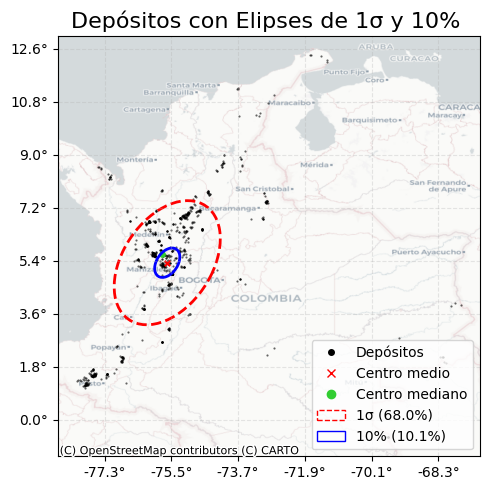

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import contextily as ctx
from shapely.geometry import Point
from shapely.affinity import scale, rotate, translate

def find_scale_for_coverage(coords, center, eigs, vecs, target_pct, tol=0.5):
    unit_circle = Point(0, 0).buffer(1, resolution=256)
    width, height = 2 * np.sqrt(eigs)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    low, high = 0.1, 4.0
    best_scale, best_pct = 1.0, 0.0

    while high - low > 0.01:
        mid = (low + high) / 2
        ellipse = scale(unit_circle, (width/2)*mid, (height/2)*mid)
        ellipse = rotate(ellipse, angle, origin=(0, 0), use_radians=False)
        ellipse = translate(ellipse, center[0], center[1])

        inside = sum(ellipse.contains(Point(x, y)) for x, y in coords)
        pct = inside / len(coords) * 100

        if pct < target_pct - tol:
            low = mid
        elif pct > target_pct + tol:
            high = mid
        else:
            best_scale, best_pct = mid, pct
            break

    if best_pct == 0.0:
        best_scale, best_pct = mid, pct

    return best_scale, best_pct

# 1. Cargar datos
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y
coords = gdf[['x','y']].values

# 2. Centros y covarianza
mean_center = coords.mean(axis=0)
med_center  = np.median(coords, axis=0)
cov = np.cov(coords.T)
eigs, vecs = np.linalg.eigh(cov)
order = eigs.argsort()[::-1]
eigs, vecs = eigs[order], vecs[:,order]
width, height = 2 * np.sqrt(eigs)
angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))

# 3. Elipse de 1σ
unit_circle = Point(0, 0).buffer(1, resolution=256)
ellipse1 = scale(unit_circle, width/2, height/2)
ellipse1 = rotate(ellipse1, angle, origin=(0,0), use_radians=False)
ellipse1 = translate(ellipse1, mean_center[0], mean_center[1])

inside1 = sum(ellipse1.contains(Point(x,y)) for x,y in coords)
pct1 = inside1 / len(coords) * 100

# 4. Escala para elipse 10%
scale10, pct10 = find_scale_for_coverage(coords, mean_center, eigs, vecs, 10)

# 5. Graficar
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(gdf['x'], gdf['y'], s=0.3, color='black', alpha=0.6, label='Depósitos')
ax.scatter(*mean_center, color='red',    marker='x', s=15, label='Centro medio')
ax.scatter(*med_center,  color='limegreen',marker='o', s=15, label='Centro mediano')

ell1_patch = Ellipse(mean_center, width, height, angle=angle,
                     edgecolor='red', facecolor='none', linestyle='--', linewidth=2,
                     label=f'1σ ({pct1:.1f}%)')
ell10_patch = Ellipse(mean_center, width*scale10, height*scale10, angle=angle,
                      edgecolor='blue', facecolor='none', linestyle='-', linewidth=2,
                      label=f'10% ({pct10:.1f}%)')
ax.add_patch(ell1_patch)
ax.add_patch(ell10_patch)

# Mapa base
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

# Ejes en grados
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x*180/20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"{y*180/20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.3)

# Leyenda manual
handles = [
    Line2D([0],[0], marker='o', color='black',     label='Depósitos',      markersize=4, linestyle=''),
    Line2D([0],[0], marker='x', color='red',       label='Centro medio',   markersize=6, linestyle=''),
    Line2D([0],[0], marker='o', color='limegreen', label='Centro mediano', markersize=6, linestyle=''),
    Patch(facecolor='none', edgecolor='red',    linestyle='--', label=f'1σ ({pct1:.1f}%)'),
    Patch(facecolor='none', edgecolor='blue', linestyle='-',  label=f'10% ({pct10:.1f}%)')
]
ax.legend(handles=handles, loc='lower right')

ax.set_title("Depósitos con Elipses de 1σ y 10% ", fontsize=16)
plt.tight_layout()
plt.show()


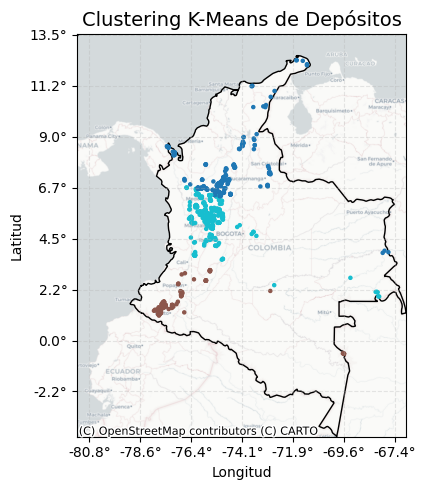

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import contextily as ctx

# === 1. Cargar shapes ===
ruta_puntos = r"C:/Git_SCA/AGE/Depositos"
ruta_colombia = r"C:/Git_SCA/AGE/Area_Col"

gdf_colombia = gpd.read_file(ruta_colombia).to_crs(epsg=3857)
gdf_puntos = gpd.read_file(ruta_puntos).to_crs(epsg=3857)

# === 2. Extraer coordenadas para clustering ===
gdf_puntos['x'] = gdf_puntos.geometry.x
gdf_puntos['y'] = gdf_puntos.geometry.y

# === 3. Aplicar K-Means ===
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
gdf_puntos['cluster'] = kmeans.fit_predict(gdf_puntos[['x', 'y']])

# === 4. Visualización ===
fig, ax = plt.subplots(figsize=(5, 5))

# Polígono transparente (solo borde)
gdf_colombia.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Puntos por cluster
gdf_puntos.plot(ax=ax, column='cluster', cmap='tab10', markersize=5, legend=False)

# Añadir mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=6)

# === 5. Coordenadas ===
# Proyectar a EPSG:4326 para que matplotlib muestre lat/lon correctos en ticks
ax.set_title("Clustering K-Means de Depósitos", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Reproyectar límites para ajustar ejes con lat/lon
bounds_4326 = gdf_colombia.to_crs(epsg=4326).total_bounds
ax.set_xlim(gdf_colombia.total_bounds[[0, 2]])
ax.set_ylim(gdf_colombia.total_bounds[[1, 3]])

# Mostrar coordenadas con formato decimal (grados)
from matplotlib.ticker import FuncFormatter

def lon_formatter(x, pos):
    return f"{x:.2f}°"

def lat_formatter(y, pos):
    return f"{y:.2f}°"

ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x*180/20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"{y*180/20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.3)


plt.tight_layout()
plt.show()


C:\TEMP\ipykernel_16192\1407670228.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')


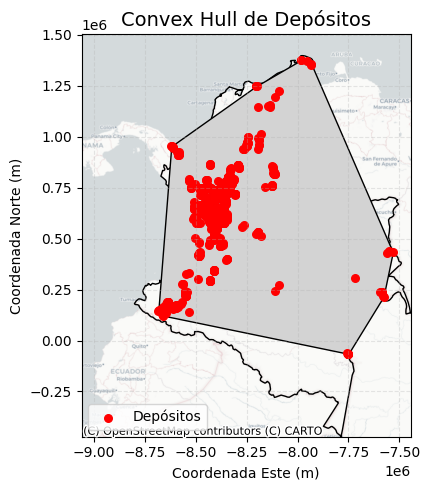

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar shapes ===
ruta_shape_principal = r"C:/Git_SCA/AGE/convex_hull"
ruta_shape_secundario = r"C:/Git_SCA/AGE/Depositos"
ruta_colombia = r"C:/Git_SCA/AGE/Area_Col"

gdf_colombia = gpd.read_file(ruta_colombia).to_crs(epsg=3857)
gdf_principal = gpd.read_file(ruta_shape_principal).to_crs(epsg=3857) 
ruta_shape_secundario = r"C:/Git_SCA/AGE/Depositos"
gdf_secundario = gpd.read_file(ruta_shape_secundario).to_crs(epsg=3857)

# === 2. Crear figura ===
fig, ax = plt.subplots(figsize=(5, 5))

# === 3. Dibujar capas ===
gdf_colombia.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, label='Colombia')  # ← corregido
gdf_principal.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1, label='Convex Hull')
ruta_shape_secundario = r"C:/Git_SCA/AGE/Depositos"
gdf_secundario = gpd.read_file(ruta_shape_secundario).to_crs(epsg=3857)
gdf_secundario.plot(ax=ax, color='red', markersize=30, label='Depósitos')

# === 4. Añadir mapa base y ajustar vista ===
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_xlim(gdf_colombia.total_bounds[[0, 2]])
ax.set_ylim(gdf_colombia.total_bounds[[1, 3]])

# === 5. Estética ===
ax.set_title("Convex Hull de Depósitos", fontsize=14)
ax.legend(loc='lower left')
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()

# === 6. Guardar imagen ===
plt.savefig("C:/Git_SCA/AGE/mapa_convex_hull.png", dpi=300, bbox_inches='tight')
plt.show()


C:\TEMP\ipykernel_16192\984780548.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull_polygon = gdf_colombia.geometry.unary_union
c:\Git_SCA\AGE\.venv\Lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


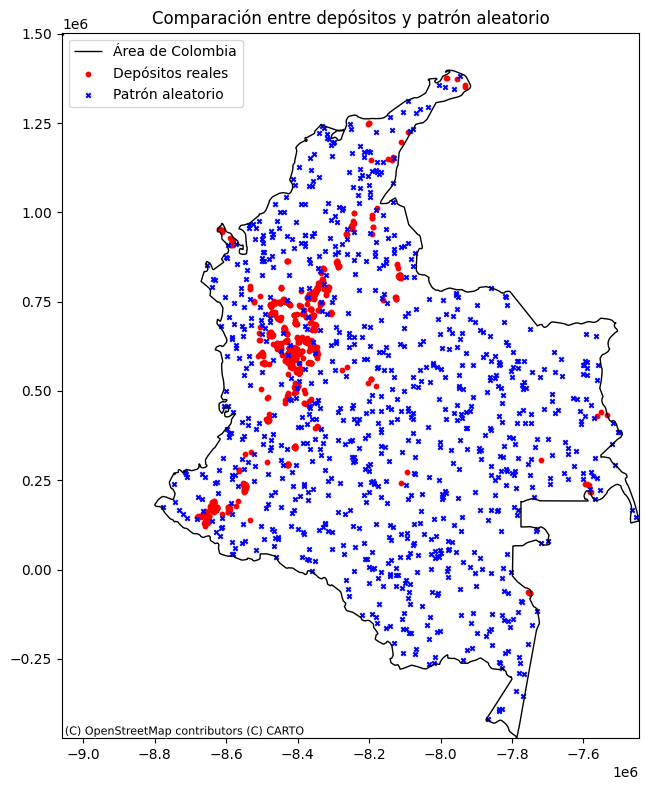

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pointpats import random

# === 1. Leer shapefiles ===
ruta_shape_secundario = r"C:/Git_SCA/AGE/Depositos"
ruta_colombia = r"C:/Git_SCA/AGE/Area_Col"

gdf_secundario = gpd.read_file(ruta_shape_secundario).to_crs(epsg=3857)
gdf_colombia = gpd.read_file(ruta_colombia).to_crs(epsg=3857)

# === 2. Unir geometría de Colombia si hay múltiples polígonos ===
hull_polygon = gdf_colombia.geometry.unary_union

# === 3. Generar puntos aleatorios dentro del polígono ===
n_points = len(gdf_secundario)  # mismo número de puntos que depósitos
random_points = random.poisson(hull_polygon, size=n_points)

# === 4. Crear GeoDataFrame de puntos aleatorios ===
gdf_random = gpd.GeoDataFrame(geometry=[Point(xy) for xy in random_points], crs=gdf_colombia.crs)

# === 5. Visualización ===
fig, ax = plt.subplots(figsize=(8, 8))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_xlim(gdf_colombia.total_bounds[[0, 2]])
ax.set_ylim(gdf_colombia.total_bounds[[1, 3]])
gdf_colombia.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='Área de Colombia')
gdf_secundario.plot(ax=ax, color='red', markersize=10, label='Depósitos reales')
gdf_random.plot(ax=ax, color='blue', markersize=10, marker='x', label='Patrón aleatorio')

ax.legend()
ax.set_title("Comparación entre depósitos y patrón aleatorio")
plt.tight_layout()
plt.show()


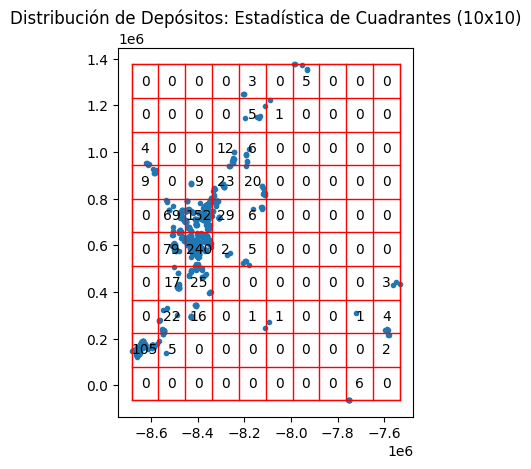

p-valor (chi² test): 0.00000
➡️ Distribución NO aleatoria: hay agrupamiento (clustering) significativo.


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pointpats import QStatistic

# === 1. Cargar tus depósitos ===
ruta_depositos = r"C:/Git_SCA/AGE/Depositos"
gdf = gpd.read_file(ruta_depositos).to_crs(epsg=3857)

# === 2. Extraer coordenadas ===
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
coordinates = gdf[['x', 'y']].values

# === 3. Calcular estadística de cuadrantes (2x2) ===
qstat = QStatistic(coordinates, nx=10, ny=10)

# === 4. Visualizar cuadrantes y puntos ===
qstat.plot()
plt.title("Distribución de Depósitos: Estadística de Cuadrantes (10x10)")
plt.show()

# === 5. Mostrar valor p de chi-cuadrado ===
print(f"p-valor (chi² test): {qstat.chi2_pvalue:.5f}")

# Interpretación básica
if qstat.chi2_pvalue < 0.05:
    print("➡️ Distribución NO aleatoria: hay agrupamiento (clustering) significativo.")
else:
    print("➡️ No hay evidencia significativa de agrupamiento (podría ser aleatoria).")


C:\TEMP\ipykernel_20464\3049301548.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Git_SCA\AGE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


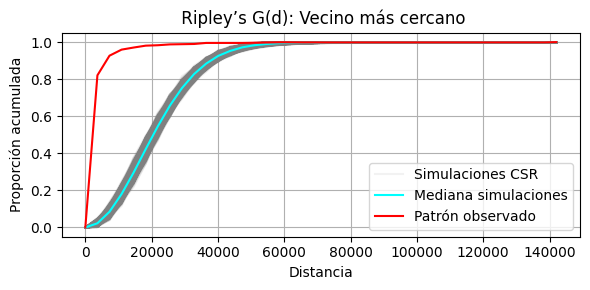

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pointpats import distance_statistics

# 1. Cargar y proyectar los datos
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
coordinates = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).to_list()
coordinates = np.array(coordinates)

# 2. Calcular G(d)
g_test = distance_statistics.g_test(coordinates, support=40, keep_simulations=True)

# 3. Graficar
plt.figure(figsize=(6, 3))

# Simulaciones
support_len = len(g_test.support)
for i in range(g_test.simulations.shape[0]):
    if i == 0:
        plt.plot(g_test.support, g_test.simulations[i, :support_len], color='gray', alpha=0.1, label='Simulaciones CSR')
    else:
        plt.plot(g_test.support, g_test.simulations[i, :support_len], color='gray', alpha=0.1)

# Mediana simulaciones
plt.plot(g_test.support, np.median(g_test.simulations[:, :support_len], axis=0), color='cyan', label='Mediana simulaciones')

# Observado
plt.plot(g_test.support, g_test.statistic[:support_len], color='red', label='Patrón observado')

# Estética
plt.title(" Ripley’s G(d): Vecino más cercano")
plt.xlabel("Distancia")
plt.ylabel("Proporción acumulada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\TEMP\ipykernel_20464\633096851.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Git_SCA\AGE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


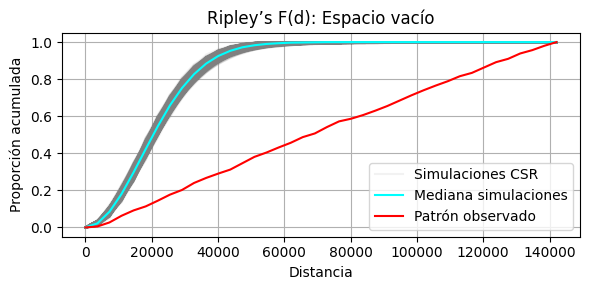

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pointpats import distance_statistics

# 1. Cargar y proyectar los datos
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
coordinates = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).to_list()
coordinates = np.array(coordinates)

# 2. Calcular F(d)
f_test = distance_statistics.f_test(coordinates, support=40, keep_simulations=True)

# 3. Graficar
plt.figure(figsize=(6, 3))

# Número de pasos de distancia
support_len = len(f_test.support)

# Simulaciones CSR
for i in range(f_test.simulations.shape[0]):
    if i == 0:
        plt.plot(f_test.support, f_test.simulations[i, :support_len], color='gray', alpha=0.1, label='Simulaciones CSR')
    else:
        plt.plot(f_test.support, f_test.simulations[i, :support_len], color='gray', alpha=0.1)

# Mediana de simulaciones
plt.plot(f_test.support, np.median(f_test.simulations[:, :support_len], axis=0), color='cyan', label='Mediana simulaciones')

# Observado
plt.plot(f_test.support, f_test.statistic[:support_len], color='red', label='Patrón observado')

# Estética
plt.title("Ripley’s F(d): Espacio vacío")
plt.xlabel("Distancia")
plt.ylabel("Proporción acumulada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Shapefile exportado exitosamente: C:/Git_SCA/AGE/Puntos_cluster/Depositos_clusterizados_DBSCAN.shp


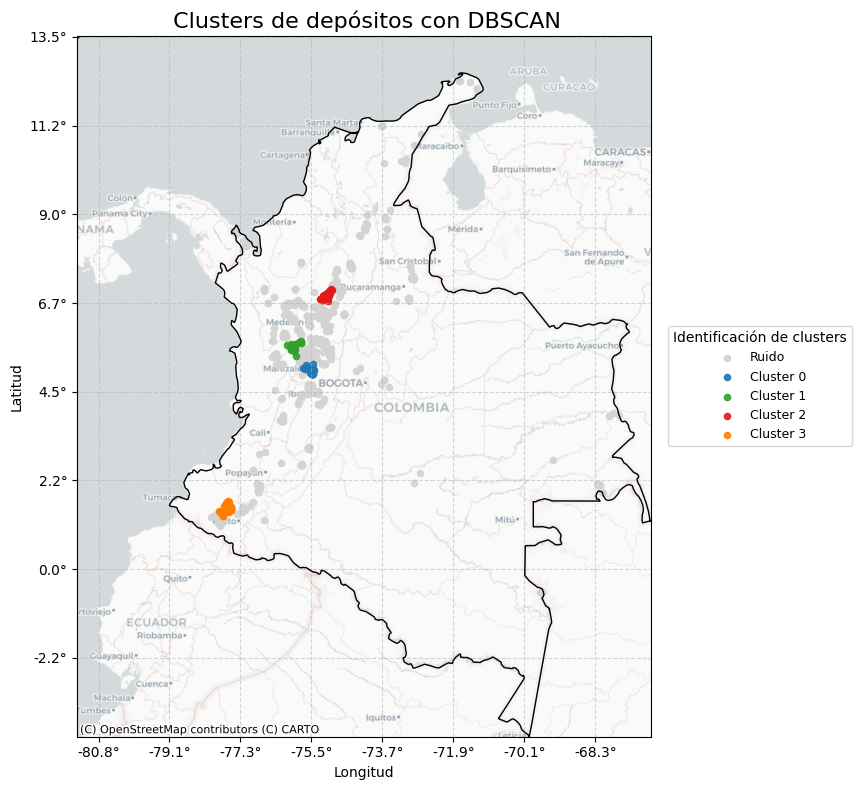

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN
import itertools
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# === 1. Cargar datos ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf_colombia = gpd.read_file(r"C:/Git_SCA/AGE/Area_Col").to_crs(epsg=3857)

# === 2. Extraer coordenadas
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# === 3. Ejecutar DBSCAN
db = DBSCAN(eps=20000, min_samples=50)
gdf['cluster'] = db.fit_predict(gdf[['x', 'y']])

# === 4. Preparar colores
colors = {
    -1: 'lightgray',  # Ruido
    0: '#1f78b4',
    1: '#33a02c',
    2: '#e31a1c',
    3: '#ff7f00',
    4: '#6a3d9a'
}
palette = itertools.cycle(mcolors.TABLEAU_COLORS)
cluster_ids = sorted(gdf['cluster'].unique())
for i in cluster_ids:
    if i not in colors:
        colors[i] = next(palette)

# === 5. Visualización ===
fig, ax = plt.subplots(figsize=(8, 8))

# Contorno de Colombia
gdf_colombia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Dibujar puntos por cluster
for cl in cluster_ids:
    cluster_data = gdf[gdf['cluster'] == cl]
    label = f"Cluster {cl}" if cl != -1 else "Ruido"
    ax.scatter(
        cluster_data['x'],
        cluster_data['y'],
        label=label,
        s=20,
        alpha=0.9,
        color=colors[cl]
    )

# Añadir mapa base
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

# Límites del mapa (todo Colombia)
ax.set_xlim(gdf_colombia.total_bounds[[0, 2]])
ax.set_ylim(gdf_colombia.total_bounds[[1, 3]])

# === 6. Formatear ejes con coordenadas en grados decimales ===
def coord_formatter(x, _): return f"{x * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(coord_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(coord_formatter))
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# === 7. Estética ===
ax.set_title(" Clusters de depósitos con DBSCAN", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# === 8. Leyenda fuera del mapa ===
ax.legend(
    title="Identificación de clusters",
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    title_fontsize=10
)
# === 9. Exportar resultados como Shapefile ===
# Crear una copia del GeoDataFrame solo con columnas clave
gdf_export = gdf[['geometry', 'cluster']].copy()

# Definir ruta de salida (ajústala si deseas otro nombre o ubicación)
ruta_salida = r"C:/Git_SCA/AGE/Puntos_cluster/Depositos_clusterizados_DBSCAN.shp"

# Guardar como shapefile
gdf_export.to_file(ruta_salida)

print("✅ Shapefile exportado exitosamente:", ruta_salida)

plt.tight_layout()
plt.show()


c:\Git_SCA\AGE\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Git_SCA\AGE\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Polígonos de clústeres exportados como Shapefile.


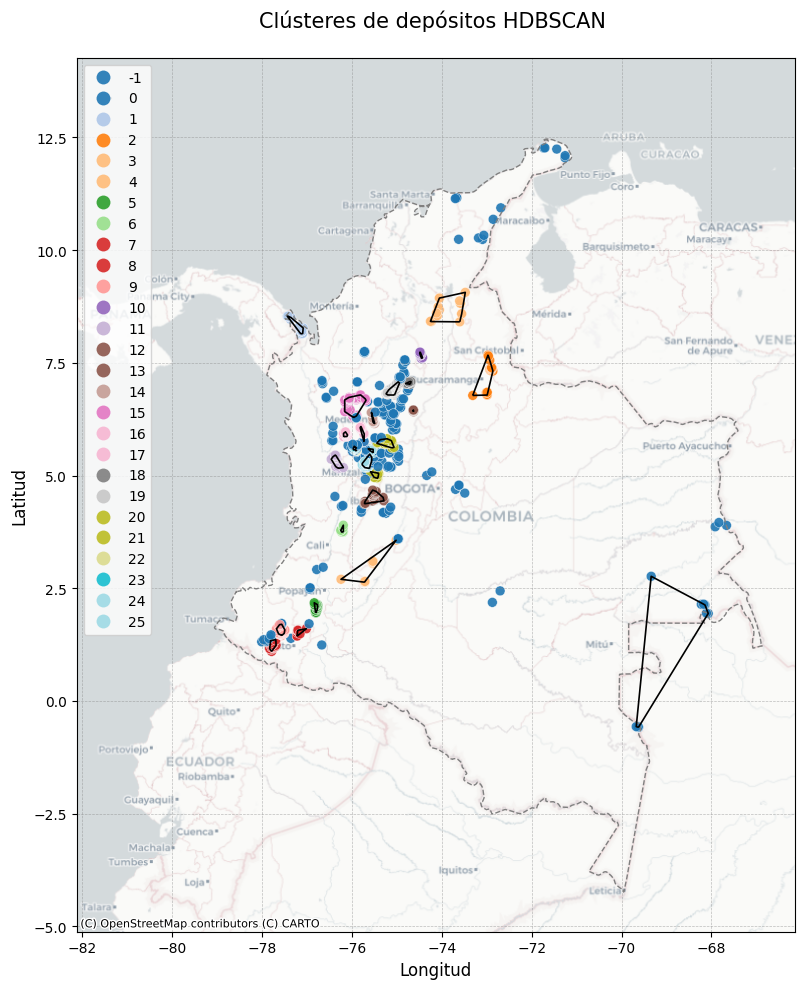

In [ ]:
# === Librerías necesarias ===
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
from hdbscan import HDBSCAN

# === 1. Leer shapefiles y reproyectar a coordenadas métricas ===
ruta_depositos = r"C:/Git_SCA/AGE/Depositos"
ruta_colombia = r"C:/Git_SCA/AGE/Area_Col"

gdf = gpd.read_file(ruta_depositos).to_crs(epsg=3857)
gdf_colombia = gpd.read_file(ruta_colombia).to_crs(epsg=3857)

# === 2. Calcular coordenadas X, Y y matriz para clustering ===
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
coords = np.column_stack((gdf['x'], gdf['y']))

# === 3. Aplicar HDBSCAN ===
hdb = HDBSCAN(min_cluster_size=10)
gdf['cluster_id'] = hdb.fit_predict(coords)

# === 4. Calcular envolventes convexas por clúster (sin ruido) ===
gdf_clusters = gdf[gdf['cluster_id'] >= 0]
hulls = gdf_clusters.dissolve(by='cluster_id').convex_hull

# === 5. Convertir todo a EPSG:4326 para visualización geográfica ===
gdf = gdf.to_crs(epsg=4326)
gdf_colombia = gdf_colombia.to_crs(epsg=4326)
hulls = gpd.GeoSeries(hulls, crs=3857).to_crs(epsg=4326)

# === 6. Visualización con colores mejorados ===
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar contorno del área de Colombia
gdf_colombia.boundary.plot(ax=ax, color='gray', linewidth=1, linestyle='--', label='Área de Colombia')

# Usar paleta de colores amplia
cmap = plt.get_cmap('tab20')  # hasta 20 colores bien contrastados

# Dibujar puntos por clúster
gdf.plot(
    ax=ax,
    column='cluster_id',
    categorical=True,
    legend=True,
    cmap=cmap,
    markersize=50,       # tamaño de los puntos
    alpha=0.9,           # opacidad
    edgecolor='white',   # borde blanco para visibilidad
    linewidth=0.3
)

# Dibujar contornos de los clústeres
hulls.boundary.plot(ax=ax, color='black', linewidth=1.2)

# Añadir mapa base
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

# Configurar ejes y grilla
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Título
ax.set_title("Clústeres de depósitos HDBSCAN \n", fontsize=15)
# === 8. Exportar las envolventes convexas (polígonos) como Shapefile ===

# Convertir GeoSeries a GeoDataFrame con cluster_id como índice
hulls_gdf = gpd.GeoDataFrame(
    {'cluster_id': hulls.index},  # Asignar el ID de clúster como campo
    geometry=hulls.values,
    crs="EPSG:4326"
)

# Ruta de salida
ruta_salida = r"C:/Git_SCA/AGE//Poligonos_clusterhdbscan/Poligonos_Clusters.shp"

# Guardar
hulls_gdf.to_file(ruta_salida)

print("✅ Polígonos de clústeres exportados como Shapefile.")

# Ajuste final
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

           0       0.65      0.25      0.37       244
           1       0.55      0.87      0.68       257

    accuracy                           0.57       501
   macro avg       0.60      0.56      0.52       501
weighted avg       0.60      0.57      0.52       501



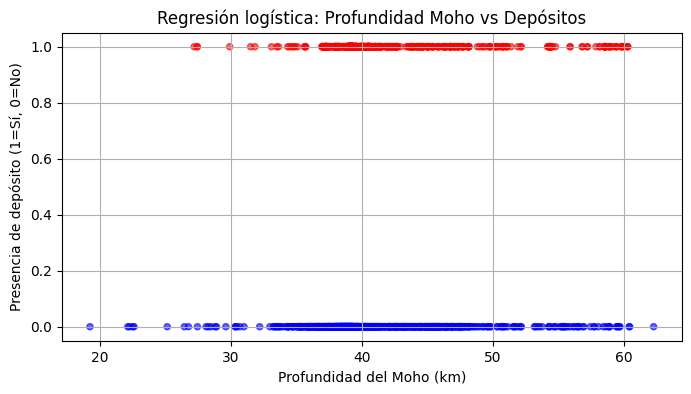

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin

# 1. Cargar shapefiles (ajusta las rutas a tu entorno)
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho      = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_colombia  = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)

# 2. Extraer el polígono de Colombia
col_union = gdf_colombia.unary_union

# 3. Filtrar puntos de Moho al interior de Colombia sin usar sjoin
moho_points = []
moho_values = []
for idx, row in gdf_moho.iterrows():
    pt = row.geometry
    if col_union.contains(pt):
        moho_points.append((pt.x, pt.y))
        moho_values.append(row["Z"])  # columna con la profundidad

coords_moho = np.array(moho_points)
z_moho      = np.array(moho_values)

# 4. Interpolación de Moho sobre grilla regular (lon: -80 a -65; lat: -5 a 15)
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_z = griddata(coords_moho, z_moho, (grid_x, grid_y), method="cubic")

# 5. (Opcional) guardar el ráster de Moho interpolado
transform = from_origin(-80, 15, (15)/500, (20)/500)
with rasterio.open(
    "C:/Git_SCA/AGE/moho_interpolado.tif", "w", driver="GTiff",
    height=grid_z.shape[0], width=grid_z.shape[1],
    count=1, dtype="float32", crs="EPSG:4326", transform=transform
) as dst:
    dst.write(grid_z.astype("float32"), 1)

# 6. Generar pseudo-ausencias dentro de Colombia pero fuera de depósitos
num_depos = len(gdf_depositos)
pseudo = []
rng = np.random.default_rng(42)
minx, miny, maxx, maxy = -80, -5, -65, 15

while len(pseudo) < num_depos:
    x, y = rng.uniform(minx, maxx), rng.uniform(miny, maxy)
    p = Point(x, y)
    if col_union.contains(p):
        # comprobar que NO intersecte con ningún depósito
        if not any(pt.within(Point(d.x, d.y).buffer(0.0001)) for d, pt in 
                   zip(gdf_depositos.geometry, [p])):
            pseudo.append(p)

gdf_aus = gpd.GeoDataFrame(geometry=pseudo, crs="EPSG:4326")
gdf_aus["Presencia"] = 0
gdf_depositos["Presencia"] = 1

# 7. Unir presencia y ausencia, y extraer coordenadas
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# 8. Función para muestrear el valor interpolado de Moho
def sample_moho(x, y):
    # calculo de índices en la grilla
    ix = int((x - (-80))   / ((-65 - (-80)) / 500))
    iy = int((15 - y)      / ((15 - (-5))    / 500))
    if 0 <= ix < 500 and 0 <= iy < 500:
        return grid_z[iy, ix]
    else:
        return np.nan

gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_moho(r.X, r.Y), axis=1)
gdf_total = gdf_total.dropna(subset=["Moho_Z"])

# 9. Preparar X, y y ajustar regresión logística
X = gdf_total[["Moho_Z"]].values
y = gdf_total["Presencia"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# 10. Gráfica final
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.scatter(gdf_total["Moho_Z"], gdf_total["Presencia"],
            c=gdf_total["Presencia"], cmap="bwr", s=20, alpha=0.6)
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("Presencia de depósito (1=Sí, 0=No)")
plt.title("Regresión logística: Profundidad Moho vs Depósitos")
plt.grid(True)
plt.show()


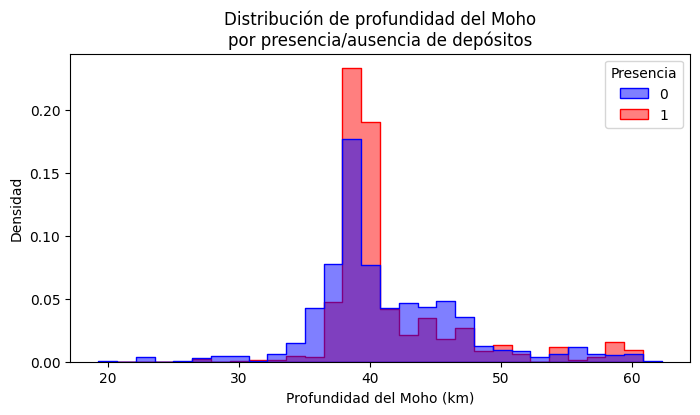

C:\TEMP\ipykernel_1604\2260146694.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=gdf_total, x="Presencia", y="Moho_Z",


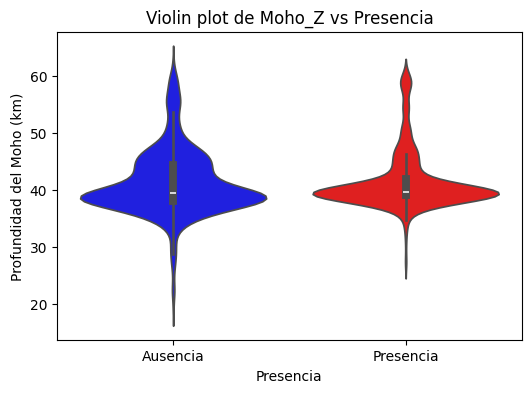

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(data=gdf_total, x="Moho_Z", hue="Presencia",
             element="step", stat="density", common_norm=False,
             palette=["blue","red"], alpha=0.5, bins=30)
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("Densidad")
plt.title("Distribución de profundidad del Moho\npor presencia/ausencia de depósitos")
plt.show()

# O un violin plot:
plt.figure(figsize=(6,4))
sns.violinplot(data=gdf_total, x="Presencia", y="Moho_Z",
               palette=["blue","red"])
plt.xticks([0,1], ["Ausencia","Presencia"])
plt.ylabel("Profundidad del Moho (km)")
plt.title("Violin plot de Moho_Z vs Presencia")
plt.show()


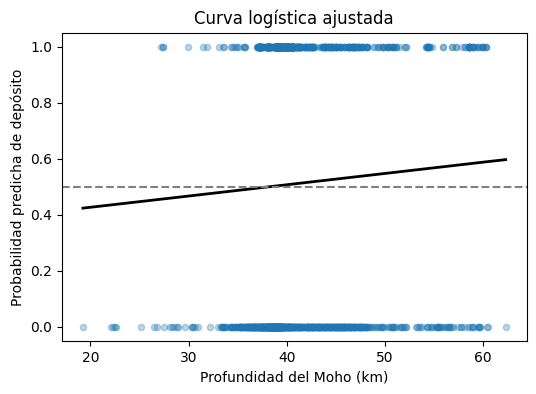

In [ ]:
import numpy as np

# extrae coeficientes
b0, b1 = model.intercept_[0], model.coef_[0][0]

# rango de profundidades
zs = np.linspace(gdf_total["Moho_Z"].min(), gdf_total["Moho_Z"].max(), 200)
probs = 1 / (1 + np.exp(-(b0 + b1 * zs)))

plt.figure(figsize=(6,4))
plt.scatter(gdf_total["Moho_Z"], gdf_total["Presencia"], alpha=0.3, s=20)
plt.plot(zs, probs, color="black", lw=2)
plt.axhline(0.5, color="gray", ls="--")
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("Probabilidad predicha de depósito")
plt.title("Curva logística ajustada")
plt.show()


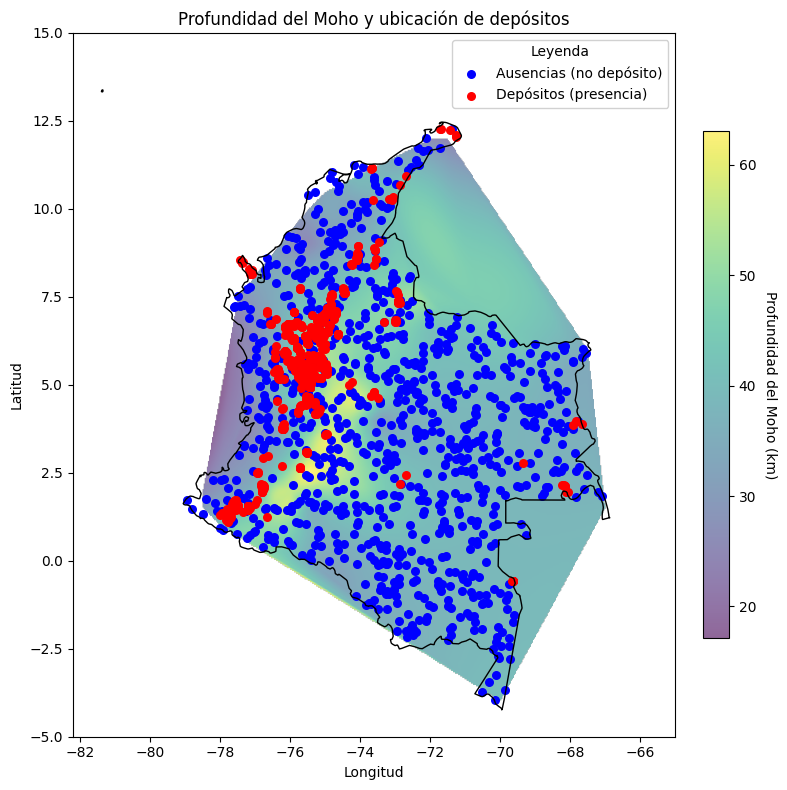

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# 1. Mostrar interpolación como imagen y añadir colorbar
img = ax.imshow(
    grid_z.T, 
    origin="lower", 
    extent=[-80, -65, -5, 15],
    cmap="viridis", 
    alpha=0.6
)
cbar = fig.colorbar(img, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("Profundidad del Moho (km)", rotation=270, labelpad=15)

# 2. Dibujar contorno de Colombia
gdf_colombia.boundary.plot(ax=ax, edgecolor="black", lw=1)

# 3. Dibujar puntos de ausencia y presencia con etiquetas
aus = gdf_aus.plot(
    ax=ax, color="blue", markersize=30, label="Ausencias (no depósito)"
)
dep = gdf_depositos.plot(
    ax=ax, color="red", markersize=30, label="Depósitos (presencia)"
)

# 4. Etiquetas y título
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_title("Profundidad del Moho y ubicación de depósitos")

# 5. Leyenda
ax.legend(
    title="Leyenda",
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.9
)

plt.tight_layout()
plt.show()


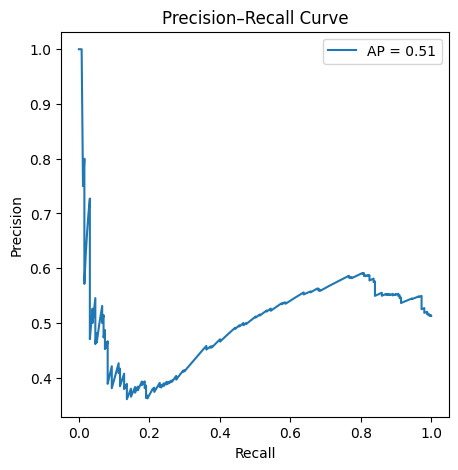

In [ ]:
# Después de haber entrenado tu modelo...
# Por ejemplo:
# model = LogisticRegression().fit(X_train, y_train)

# 1) Obtén las probabilidades de clase 1 sobre el conjunto de test:
y_prob = model.predict_proba(X_test)[:, 1]

# 2) Ahora sí puedes trazar la curva Precision–Recall:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(5,5))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


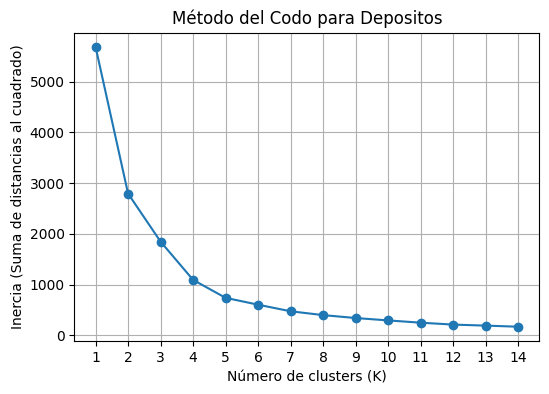

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Carga tus depósitos y extrae coordenadas
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
coords = np.vstack([gdf_depositos.geometry.x, gdf_depositos.geometry.y]).T

# 2. Probar varios valores de K y guardar la inercia
inertias = []
K_range = range(1, 15)  # prueba K = 1..14
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(coords)
    inertias.append(km.inertia_)

# 3. Dibujar la curva del codo
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, '-o', color='tab:blue')
plt.xticks(K_range)
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias al cuadrado)")
plt.title("Método del Codo para Depositos")
plt.grid(True)
plt.show()


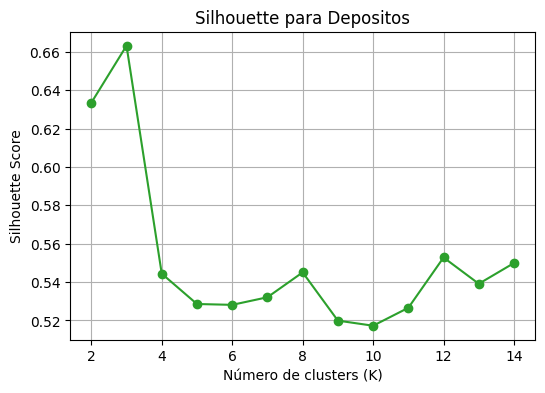

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(coords)
    sil_scores.append(silhouette_score(coords, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(range(2,15), sil_scores, '-o', color='tab:green')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette para Depositos")
plt.grid(True)
plt.show()


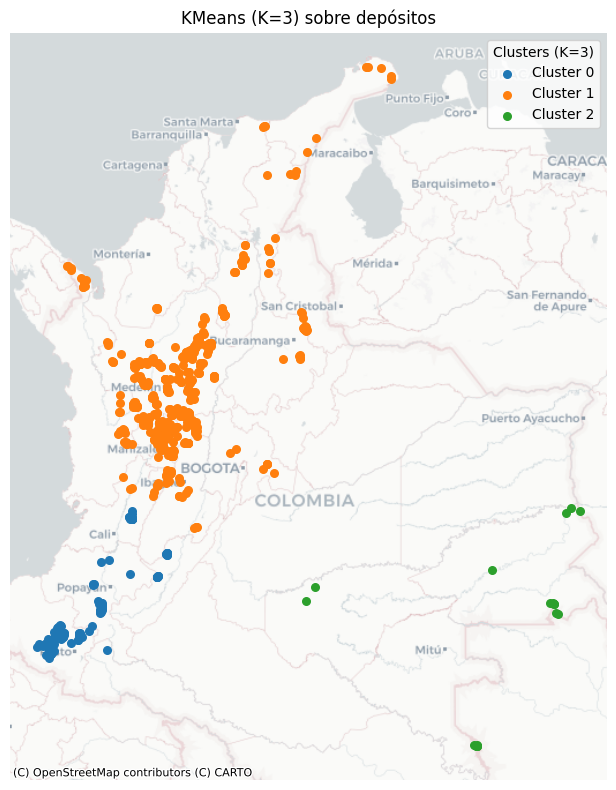

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import contextily as ctx

# 1. Carga y extrae coordenadas
gdf = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
coords = np.stack([gdf.geometry.x, gdf.geometry.y], axis=1)

# 2. Ajusta KMeans con K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
gdf["cluster3"] = kmeans.fit_predict(coords)

# 3. Elegir una paleta de colores
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# 4. Mapear clusters
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i, col in enumerate(colors):
    subset = gdf[gdf["cluster3"] == i]
    subset.plot(ax=ax, markersize=30, color=col, label=f"Cluster {i}")

# 5. Añadir basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.legend(title="Clusters (K=3)", loc="upper right")
ax.set_title("KMeans (K=3) sobre depósitos")
plt.tight_layout()
plt.show()


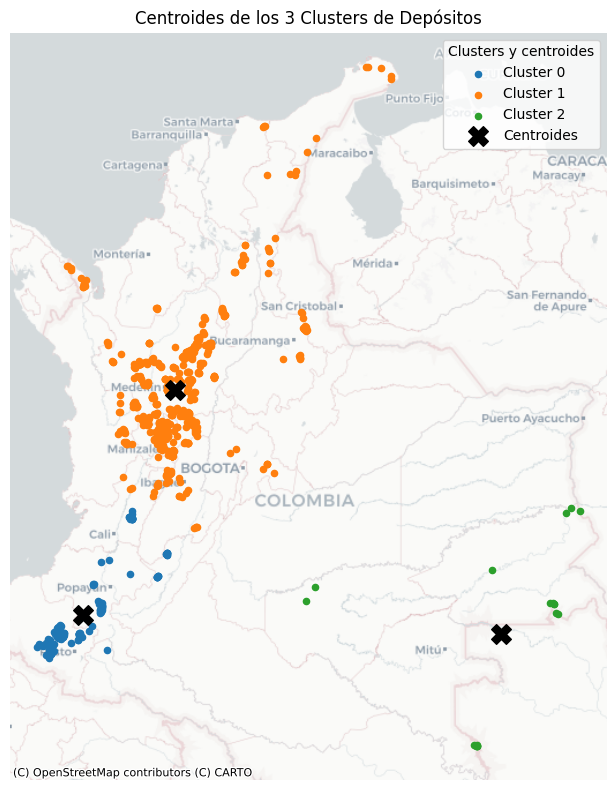

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
import contextily as ctx

# --- 1. Leer depósitos y proyectar a WebMercator para contextily ---
gdf = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
coords = np.stack([gdf.geometry.x, gdf.geometry.y], axis=1)

# --- 2. Ajustar KMeans con K=3 (si ya lo tienes, salta este paso) ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
gdf["cluster3"] = kmeans.fit_predict(coords)

# --- 3. Crear GeoSeries con los centroides ---
centroids = gpd.GeoSeries(
    [Point(x, y) for x, y in kmeans.cluster_centers_],
    crs="EPSG:3857"
)

# --- 4. Plot ---
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Mapa base de depósitoss coloreados por cluster
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
for i, color in enumerate(colors):
    gdf[gdf["cluster3"] == i].plot(
        ax=ax, 
        marker="o", 
        color=color, 
        markersize=20, 
        label=f"Cluster {i}"
    )

# Añadir centroides
centroids.plot(
    ax=ax, 
    marker="X", 
    color="black", 
    markersize=200, 
    label="Centroides"
)

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Ajustes finales
ax.set_axis_off()
ax.legend(title="Clusters y centroides", loc="upper right")
ax.set_title("Centroides de los 3 Clusters de Depósitos")
plt.tight_layout()
plt.show()


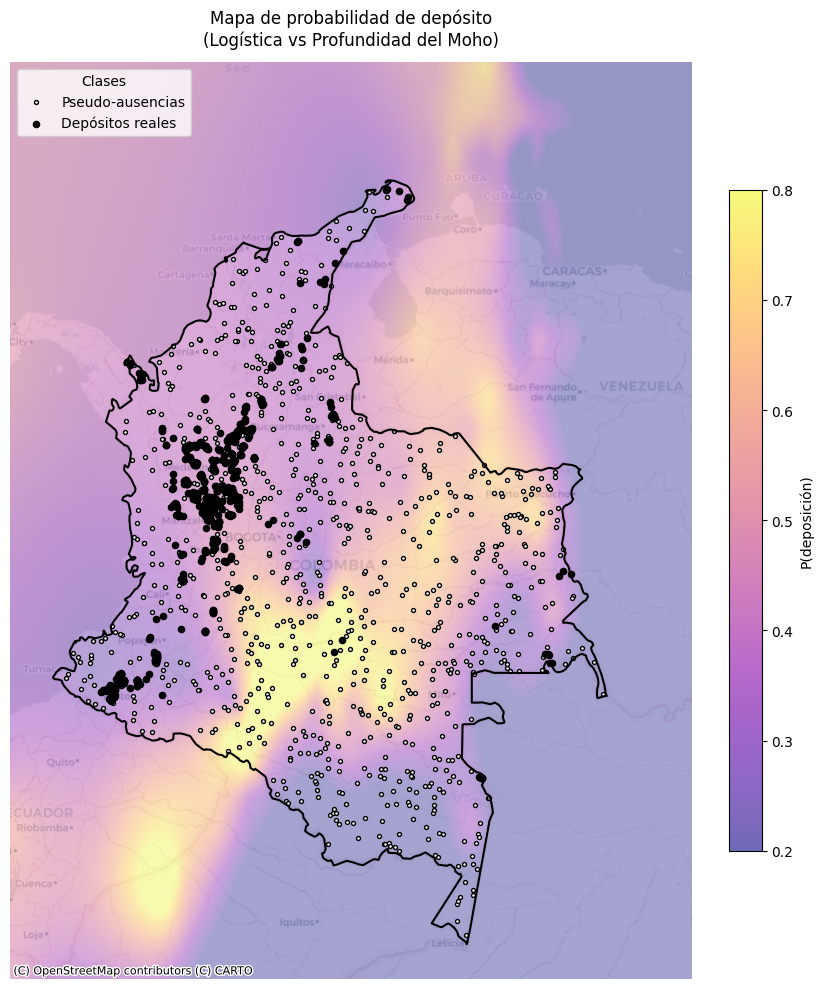

In [ ]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import griddata
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
from shapely.geometry import Point
import pandas as pd
import random

# Parámetros del área y grilla
minx, miny, maxx, maxy = -80, -5, -65, 15
n_grid = 300

# 1) Carga y grilla de Moho (EPSG:4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
coords_m = np.vstack([gdf_moho.geometry.x, gdf_moho.geometry.y]).T
vals_m   = gdf_moho["Z"].values

# 2) Genera la grilla lon/lat
lon = np.linspace(minx, maxx, n_grid)
lat = np.linspace(miny, maxy, n_grid)
LON, LAT = np.meshgrid(lon, lat)

# 3) Interpola Moho en la grilla
grid_z = griddata(coords_m, vals_m, (LON, LAT), method="cubic")
mask_nan = np.isnan(grid_z)
grid_z[mask_nan] = griddata(coords_m, vals_m,
                            (LON[mask_nan], LAT[mask_nan]),
                            method="nearest")

# 4) Carga depósitos y extrae su profundidad
gdf_dep = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
coords_dep = np.vstack([gdf_dep.geometry.x, gdf_dep.geometry.y]).T
moho_dep = griddata(
    (LON.flatten(), LAT.flatten()),
    grid_z.flatten(),
    (coords_dep[:,0], coords_dep[:,1]),
    method="cubic"
)
gdf_dep["moho"] = moho_dep
gdf_dep = gdf_dep.dropna(subset=["moho"])
gdf_dep["Presencia"] = 1

# 5) Genera pseudo-ausencias dentro de Colombia
gdf_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
poly_col = gdf_col.unary_union

abs_pts = []
while len(abs_pts) < len(gdf_dep):
    x0 = random.uniform(minx, maxx)
    y0 = random.uniform(miny, maxy)
    p0 = Point(x0, y0)
    if poly_col.contains(p0):
        abs_pts.append(p0)

gdf_abs = gpd.GeoDataFrame(geometry=abs_pts, crs="EPSG:4326")
coords_abs = np.vstack([gdf_abs.geometry.x, gdf_abs.geometry.y]).T
moho_abs = griddata(
    (LON.flatten(), LAT.flatten()),
    grid_z.flatten(),
    (coords_abs[:,0], coords_abs[:,1]),
    method="cubic"
)
gdf_abs["moho"] = moho_abs
gdf_abs = gdf_abs.dropna(subset=["moho"])
gdf_abs["Presencia"] = 0

# 6) Combina y entrena
gdf_train = pd.concat([gdf_dep, gdf_abs], ignore_index=True)
X = gdf_train[["moho"]].values
y = gdf_train["Presencia"].values
model = LogisticRegression().fit(X, y)

# 7) Predecir probabilidades en la grilla
probs = model.predict_proba(grid_z.flatten().reshape(-1,1))[:,1].reshape(grid_z.shape)

# 8) Proyección a WebMercator
tf = Transformer.from_crs("EPSG:4326","EPSG:3857", always_xy=True)
Xm, Ym = tf.transform(LON, LAT)

# 9) Dibujar
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Heatmap de probabilidades
im = ax.imshow(
    probs.T,
    origin="lower",
    extent=[Xm.min(), Xm.max(), Ym.min(), Ym.max()],
    cmap="plasma",          # colormap distinto
    alpha=0.6
)
# Ajusta límites de color
im.set_clim(0.2, 0.8)

# Barra de color
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("P(deposición)")

# Añade el basemap con algo de transparencia
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    alpha=0.4,
    zoom=6
)

# Contorno de Colombia
gdf_col.to_crs(epsg=3857).boundary.plot(
    ax=ax, edgecolor="black", linewidth=1.5
)

# Depósitos reales y pseudo-ausencias
gdf_abs.to_crs(epsg=3857).plot(
    ax=ax,
    color="white",
    edgecolor="black",
    markersize=8,
    label="Pseudo-ausencias"
)
gdf_dep.to_crs(epsg=3857).plot(
    ax=ax,
    color="black",
    markersize=20,
    label="Depósitos reales"
)

# Leyenda y estética
ax.set_axis_off()
ax.legend(loc="upper left", title="Clases")
ax.set_title("Mapa de probabilidad de depósito\n(Logística vs Profundidad del Moho)", pad=12)

plt.tight_layout()
# opcional: guardar figura
# fig.savefig("mapa_probabilidad_depositos.png", dpi=300)

plt.show()


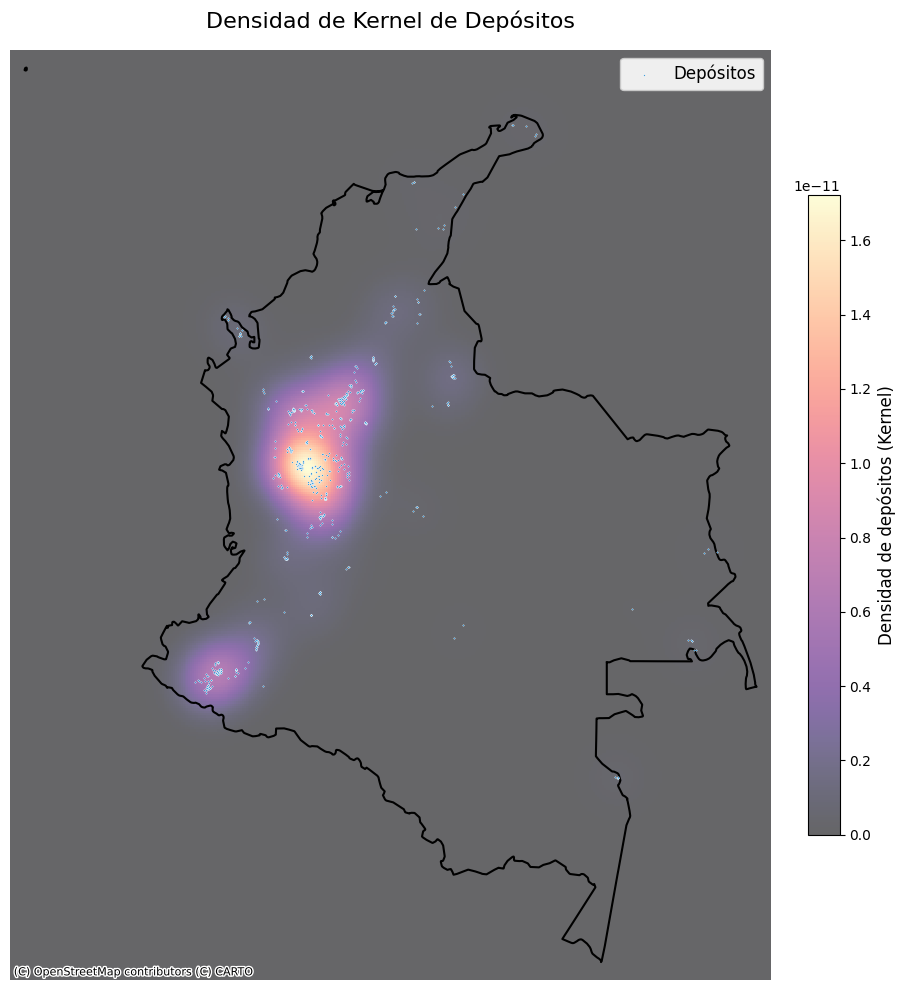

In [ ]:
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import contextily as ctx

# 1) Carga y reproyección
gdf_dep = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=3857)

# 2) Extraer coords y definir KDE
coords = np.vstack([gdf_dep.geometry.x, gdf_dep.geometry.y]).T
kde = KernelDensity(bandwidth=50000, kernel="gaussian", algorithm="ball_tree")
kde.fit(coords)

# 3) Grilla sobre Colombia
minx, miny, maxx, maxy = gdf_col.total_bounds
pad = 0.02  # pequeño margen
dx, dy = maxx-minx, maxy-miny
minx, maxx = minx-pad*dx, maxx+pad*dx
miny, maxy = miny-pad*dy, maxy+pad*dy

n = 400
xv = np.linspace(minx, maxx, n)
yv = np.linspace(miny, maxy, n)
X, Y = np.meshgrid(xv, yv)
grid_pts = np.vstack([X.ravel(), Y.ravel()]).T

# 4) Evaluar KDE y remodelar
Z = np.exp(kde.score_samples(grid_pts)).reshape(n, n)

# 5) Dibujo
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_facecolor("white")

# 5.1 Basemap primero, semitransparente
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron, 
    zoom=6, 
    alpha=0.5
)

# 5.2 Heatmap de densidad (por debajo de los depósitos)
mesh = ax.pcolormesh(
    X, Y, Z, 
    cmap="magma", 
    shading="auto", 
    alpha=0.6,
    zorder=1
)

# 5.3 Contorno de Colombia
gdf_col.boundary.plot(
    ax=ax, 
    edgecolor="black", 
    linewidth=1.5,
    zorder=2
)

# 5.4 Depósitos sobre el heatmap
gdf_dep.plot(
    ax=ax,
    markersize=1,
    color="#007acc",
    edgecolor="white",
    linewidth=0.3,
    label="Depósitos",
    zorder=3
)

# 6) Colorbar estética
cbar = fig.colorbar(
    mesh, 
    ax=ax, 
    fraction=0.035, 
    pad=0.04
)
cbar.set_label("Densidad de depósitos (Kernel)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# 7) Limpieza final
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()
ax.legend(
    loc="upper right", 
    frameon=True, 
    framealpha=0.9, 
    fontsize=12
)
ax.set_title(
    "Densidad de Kernel de Depósitos", 
    fontsize=16, 
    pad=16
)

plt.tight_layout()
plt.show()


C:\TEMP\ipykernel_20720\841669589.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if gdf_depositos.geometry.distance(p).min() > 0.01:


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.446     0.577     0.503       267
           1      0.399     0.282     0.330       266

    accuracy                          0.430       533
   macro avg      0.423     0.429     0.417       533
weighted avg      0.423     0.430     0.417       533

Confusion Matrix:
 [[154 113]
 [191  75]]
Accuracy: 0.430
ROC AUC:   0.513

Intercept (log‐odds): -0.831
Coef Moho_Z:          0.020
Odds‐ratio (1 km Δ):  1.021


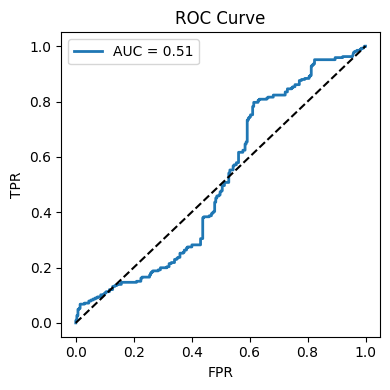

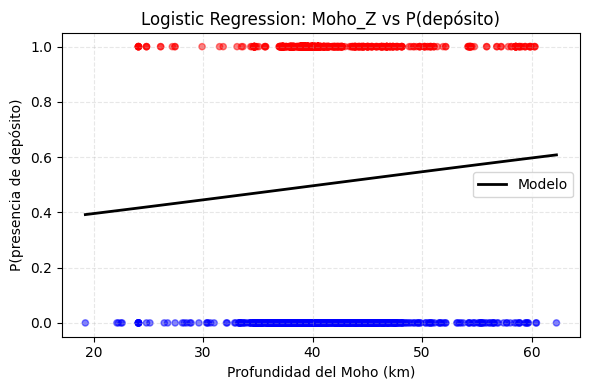

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin

# 1. Cargar y reproyectar shapefiles
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho      = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_colombia  = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)

# 2. Polígono de Colombia
col_union = gdf_colombia.unary_union

# 3. Filtrar y extraer coords+Z de Moho dentro de Colombia
pts, zs = [], []
for _, row in gdf_moho.iterrows():
    pt = row.geometry
    if col_union.contains(pt):
        pts.append((pt.x, pt.y))
        zs.append(row["Z"])  # columna de profundidad

coords_moho = np.array(pts)
z_moho      = np.array(zs)

# 4. Interpolación en malla regular (500×500 puntos)
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_z = griddata(coords_moho, z_moho, (grid_x, grid_y), method="cubic")
# Rellenar NaN con vecino más cercano
mask = np.isnan(grid_z)
grid_z[mask] = griddata(coords_moho, z_moho, (grid_x[mask], grid_y[mask]), method="nearest")

# 5. (Opcional) Guardar raster de Moho
transform = from_origin(-80, 15, 15/500, 20/500)
with rasterio.open(
    "C:/Git_SCA/AGE/moho_interpolado.tif", "w", driver="GTiff",
    height=500, width=500, count=1, dtype="float32",
    crs="EPSG:4326", transform=transform
) as dst:
    dst.write(grid_z.astype("float32"), 1)

# 6. Generar pseudo‐ausencias (misma cantidad que depósitos)
num_depos = len(gdf_depositos)
pseudo, rng = [], np.random.default_rng(42)
minx, miny, maxx, maxy = -80, -5, -65, 15

while len(pseudo) < num_depos:
    x, y = rng.uniform(minx, maxx), rng.uniform(miny, maxy)
    p = Point(x, y)
    if col_union.contains(p):
        # distancia mínima a cualquier depósito > buffer pequeño
        if gdf_depositos.geometry.distance(p).min() > 0.01:
            pseudo.append(p)

gdf_aus = gpd.GeoDataFrame(geometry=pseudo, crs="EPSG:4326")
gdf_aus["Presencia"]   = 0
gdf_depositos["Presencia"] = 1

# 7. Unir y extraer coords
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"], gdf_total["Y"] = gdf_total.geometry.x, gdf_total.geometry.y

# 8. Muestreo de Moho interpolado
def sample_moho(x, y):
    ix = int((x - minx) / ((maxx - minx) / 500))
    iy = int((maxy - y) / ((maxy - miny) / 500))
    return grid_z[iy, ix] if 0 <= ix < 500 and 0 <= iy < 500 else np.nan

gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_moho(r.X, r.Y), axis=1)
gdf_total.dropna(subset=["Moho_Z"], inplace=True)

# 9. Preparar entrenamiento / test y ajustar modelo
X = gdf_total[["Moho_Z"]].values
y = gdf_total["Presencia"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# 10. Métricas de evaluación
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC:   {auc:.3f}")

# 11. Coeficientes & Odds‐ratios
coef = model.coef_[0][0]
intercept = model.intercept_[0]
oratio = np.exp(coef)
print(f"\nIntercept (log‐odds): {intercept:.3f}")
print(f"Coef Moho_Z:          {coef:.3f}")
print(f"Odds‐ratio (1 km Δ):  {oratio:.3f}")

# 12. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 13. Gráfico final Profundidad vs Probabilidad
moho_vals = np.linspace(gdf_total["Moho_Z"].min(), gdf_total["Moho_Z"].max(), 100)
p_vals = model.predict_proba(moho_vals.reshape(-1,1))[:,1]

plt.figure(figsize=(6,4))
plt.plot(moho_vals, p_vals, 'k-', lw=2, label="Modelo")
plt.scatter(
    gdf_total["Moho_Z"], gdf_total["Presencia"],
    c=gdf_total["Presencia"], cmap="bwr", alpha=0.5, s=20
)
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("P(presencia de depósito)")
plt.title("Logistic Regression: Moho_Z vs P(depósito)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd

# 1) Lee el shapefile (ajusta la ruta a la ubicación real)
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos")

# 2) Muestra las primeras 5 filas
print(gdf_depositos.head(3))

# (Opcional) Para ver también los nombres de las columnas:
print("\nColumnas disponibles:")
print(gdf_depositos.columns.tolist())


                             IG_EST  IG_DEP   IG_MUN   IG_POB  IG_LAT_W84  \
0  Productor pasado - Cielo abierto   Valle  Bolívar  Bolívar    4.316845   
1         Productor - Cielo abierto   Valle  Bolívar  Bolívar    4.334440   
2                        Ocurrencia  Caldas    Neira    Neira    5.157379   

   IG_LON_W84                D_PR_PAL1                  D_MI_PAL1  \
0  -76.229189          Magnesita-MgCO3            Magnesita-MgCO3   
1  -76.197300          Magnesita-MgCO3            Magnesita-MgCO3   
2  -75.605610  Crisotilo-Mg3Si2O5(OH)4  Crisotilo-Mg3(Si2O5)(OH)4   

                          D_CLAS_DEP             R_RO_HUES  \
0  Asociado_a_magmas_máficos_básicos  ROCA_ÍGNEA_PLUTÓNICA   
1  Asociado_a_magmas_máficos_básicos  ROCA_ÍGNEA_PLUTÓNICA   
2  Asociado_a_magmas_máficos_básicos      ROCA_METAMÓRFICA   

                    geometry  
0  POINT (-76.22919 4.31684)  
1  POINT (-76.19730 4.33444)  
2  POINT (-75.60561 5.15738)  

Columnas disponibles:
['IG_EST', 'IG_DEP


== Reporte de Clasificación ==
              precision    recall  f1-score   support

           0       0.77      0.06      0.11      1210
           1       0.53      0.98      0.69      1286

    accuracy                           0.53      2496
   macro avg       0.65      0.52      0.40      2496
weighted avg       0.64      0.53      0.41      2496



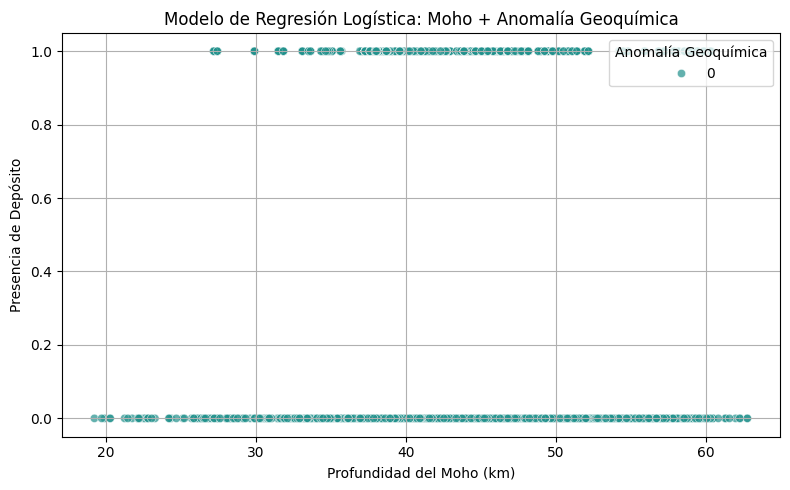

In [36]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar archivos shapefile
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
anomalias = gpd.read_file("C:/Git_SCA/AGE/Anomalias_corregido.shp").to_crs(epsg=4326)

# 2. Unir área de Colombia
col_union = area_col.unary_union

# 3. Interpolar valores Z del Moho en una grilla
moho_filtered = moho[moho.geometry.within(col_union)]
moho_points = [(p.x, p.y) for p in moho_filtered.geometry]
z_moho = moho_filtered["Z"].values
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_z = griddata(moho_points, z_moho, (grid_x, grid_y), method="cubic")

# 4. Crear puntos aleatorios negativos
rng = np.random.default_rng(42)
random_points = []
while len(random_points) < len(depositos) * 5:
    x, y = rng.uniform(-80, -65), rng.uniform(-5, 15)
    p = Point(x, y)
    if col_union.contains(p):
        random_points.append(p)

gdf_random = gpd.GeoDataFrame(geometry=random_points, crs="EPSG:4326")
gdf_random["Presencia"] = 0
gdf_random["Anomalia"] = gdf_random.geometry.within(anomalias.unary_union).astype(int)

# 5. Balancear clases: repetir depósitos
depositos_bal = pd.concat([depositos] * 5, ignore_index=True)
depositos_bal["Presencia"] = 1
depositos_bal["Anomalia"] = depositos_bal.geometry.within(anomalias.unary_union).astype(int)

# 6. Combinar datos
total = pd.concat([depositos_bal, gdf_random], ignore_index=True)
total["X"] = total.geometry.x
total["Y"] = total.geometry.y

def sample_moho(x, y):
    ix = int((x + 80) / ((-65 + 80) / 500))
    iy = int((15 - y) / ((15 + 5) / 500))
    if 0 <= ix < 500 and 0 <= iy < 500:
        return grid_z[iy, ix]
    else:
        return np.nan

total["Moho_Z"] = total.apply(lambda r: sample_moho(r.X, r.Y), axis=1)
total = total.dropna(subset=["Moho_Z", "Anomalia"])

# 7. Entrenamiento del modelo
X = total[["Moho_Z", "Anomalia"]]
y = total["Presencia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8. Reporte
print("\n== Reporte de Clasificación ==")
print(classification_report(y_test, y_pred))

# 9. Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(data=total, x="Moho_Z", y="Presencia", hue="Anomalia", palette="viridis", alpha=0.7)
plt.xlabel("Profundidad del Moho (km)")
plt.ylabel("Presencia de Depósito")
plt.title("Modelo de Regresión Logística: Moho + Anomalía Geoquímica")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Anomalía Geoquímica", loc="upper right")
plt.show()


In [49]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.interpolate import griddata
import statsmodels.api as sm

# 1. Cargar datos
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
corteza = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
anomalias = gpd.read_file("C:/Git_SCA/AGE/Anomalias_corregido.shp").to_crs(epsg=4326)

# 2. Interpolación del Moho
minx, miny, maxx, maxy = -80, -5, -65, 15
n_grid = 300
lon = np.linspace(minx, maxx, n_grid)
lat = np.linspace(miny, maxy, n_grid)
LON, LAT = np.meshgrid(lon, lat)

coords_m = np.vstack([corteza.geometry.x, corteza.geometry.y]).T
vals_m = corteza["Z"].values
grid_z = griddata(coords_m, vals_m, (LON, LAT), method="cubic")
mask_nan = np.isnan(grid_z)
grid_z[mask_nan] = griddata(coords_m, vals_m, (LON[mask_nan], LAT[mask_nan]), method="nearest")

# 3. Datos para depósitos
coords_dep = np.vstack([depositos.geometry.x, depositos.geometry.y]).T
moho_dep = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (coords_dep[:, 0], coords_dep[:, 1]), method="cubic")
depositos["moho"] = moho_dep
depositos["Presencia"] = 1
depositos["anomalia"] = depositos.geometry.within(anomalias.unary_union).astype(int)
depositos = depositos.dropna(subset=["moho"])

# 4. Pseudo-ausencias
col_union = area_col.unary_union
abs_pts = []
rng = np.random.default_rng(42)
while len(abs_pts) < len(depositos):
    x, y = rng.uniform(minx, maxx), rng.uniform(miny, maxy)
    p = Point(x, y)
    if col_union.contains(p):
        abs_pts.append(p)

gdf_abs = gpd.GeoDataFrame(geometry=abs_pts, crs="EPSG:4326")
coords_abs = np.vstack([gdf_abs.geometry.x, gdf_abs.geometry.y]).T
moho_abs = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (coords_abs[:, 0], coords_abs[:, 1]), method="cubic")
gdf_abs["moho"] = moho_abs
gdf_abs["Presencia"] = 0
gdf_abs["anomalia"] = gdf_abs.geometry.within(anomalias.unary_union).astype(int)
gdf_abs = gdf_abs.dropna(subset=["moho"])

# 5. Modelo
data = pd.concat([depositos, gdf_abs], ignore_index=True)
X = data[["moho", "anomalia"]].values
y = data["Presencia"].values

# 6. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 7. Modelo sklearn
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n== Matriz de Confusión ==")
print(confusion_matrix(y_test, y_pred))

print("\n== Reporte de Clasificación ==")
print(classification_report(y_test, y_pred))

print("\n== Precisión General ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.metrics import log_loss

# Log-verosimilitud del modelo ajustado
llf = -log_loss(y_train, model.predict_proba(X_train), normalize=False)

# Log-verosimilitud del modelo nulo
p_null = np.mean(y_train)
llnull = -log_loss(y_train, np.full_like(y_train, p_null), normalize=False)

# McFadden’s pseudo-R²
r2_mcfadden = 1 - (llf / llnull)
print(f"McFadden's R² (manual): {r2_mcfadden:.4f}")



== Matriz de Confusión ==
[[160  62]
 [ 72 150]]

== Reporte de Clasificación ==
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       222
           1       0.71      0.68      0.69       222

    accuracy                           0.70       444
   macro avg       0.70      0.70      0.70       444
weighted avg       0.70      0.70      0.70       444


== Precisión General ==
Accuracy: 0.6982
McFadden's R² (manual): 0.9646


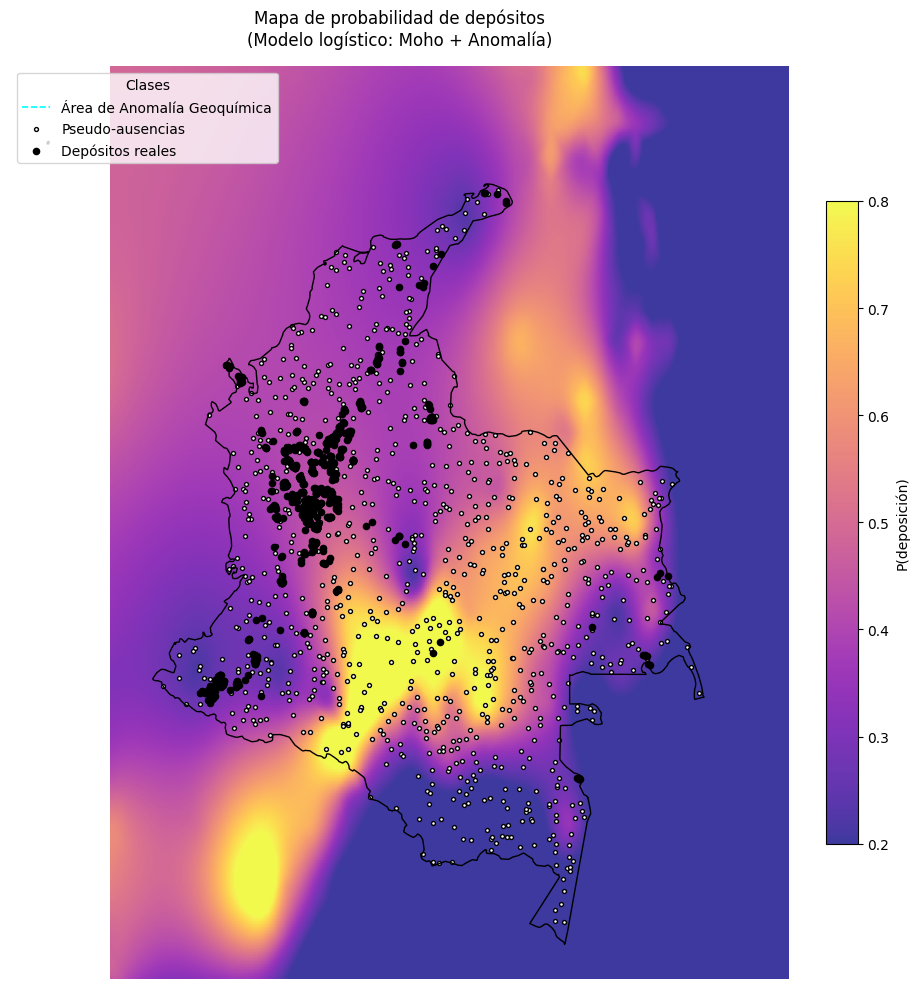

In [43]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point
from pyproj import Transformer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import random

# 1. Parámetros espaciales
minx, miny, maxx, maxy = -80, -5, -65, 15
n_grid = 300

# 2. Cargar datos
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dep = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_anom = gpd.read_file("C:/Git_SCA/AGE/Anomalias_corregido.shp").to_crs(epsg=4326)
gdf_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
poly_col = gdf_col.unary_union
poly_anom = gdf_anom.unary_union

# 3. Crear malla e interpolar moho
lon = np.linspace(minx, maxx, n_grid)
lat = np.linspace(miny, maxy, n_grid)
LON, LAT = np.meshgrid(lon, lat)
coords_m = np.vstack([gdf_moho.geometry.x, gdf_moho.geometry.y]).T
vals_m = gdf_moho["Z"].values
grid_z = griddata(coords_m, vals_m, (LON, LAT), method="cubic")
grid_z[np.isnan(grid_z)] = griddata(coords_m, vals_m, (LON[np.isnan(grid_z)], LAT[np.isnan(grid_z)]), method="nearest")

# 4. Extraer moho + etiqueta anomalía para depósitos
coords_dep = np.vstack([gdf_dep.geometry.x, gdf_dep.geometry.y]).T
gdf_dep["moho"] = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (coords_dep[:,0], coords_dep[:,1]), method="cubic")
gdf_dep = gdf_dep.dropna(subset=["moho"])
gdf_dep["Presencia"] = 1
gdf_dep["Anomalia"] = gdf_dep.geometry.within(poly_anom).astype(int)

# 5. Generar pseudo-ausencias balanceadas
abs_pts = []
while len(abs_pts) < len(gdf_dep):
    x0, y0 = random.uniform(minx, maxx), random.uniform(miny, maxy)
    p0 = Point(x0, y0)
    if poly_col.contains(p0):
        abs_pts.append(p0)
gdf_abs = gpd.GeoDataFrame(geometry=abs_pts, crs="EPSG:4326")
coords_abs = np.vstack([gdf_abs.geometry.x, gdf_abs.geometry.y]).T
gdf_abs["moho"] = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (coords_abs[:,0], coords_abs[:,1]), method="cubic")
gdf_abs = gdf_abs.dropna(subset=["moho"])
gdf_abs["Presencia"] = 0
gdf_abs["Anomalia"] = gdf_abs.geometry.within(poly_anom).astype(int)

# 6. Modelo
gdf_train = pd.concat([gdf_dep, gdf_abs], ignore_index=True)
X = gdf_train[["moho", "Anomalia"]].values
y = gdf_train["Presencia"].values
model = LogisticRegression(max_iter=1000).fit(X, y)

# 7. Predecir en malla
grid_flat = np.column_stack([grid_z.flatten(), np.zeros(grid_z.size)])  # anomalia = 0 por defecto
probs_base = model.predict_proba(grid_flat)[:,1].reshape(grid_z.shape)

grid_flat_1 = np.column_stack([grid_z.flatten(), np.ones(grid_z.size)])  # anomalia = 1
probs_anom = model.predict_proba(grid_flat_1)[:,1].reshape(grid_z.shape)

# 8. Proyección WebMercator
tf = Transformer.from_crs("EPSG:4326","EPSG:3857", always_xy=True)
Xm, Ym = tf.transform(LON, LAT)

# 9. Visualizar
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Mapa de probabilidad (promedio entre presencia y ausencia de anomalía)
probs_comb = (probs_base + probs_anom) / 2
im = ax.imshow(probs_comb.T, origin="lower", extent=[Xm.min(), Xm.max(), Ym.min(), Ym.max()], cmap="plasma", alpha=0.8)
im.set_clim(0.2, 0.8)
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("P(deposición)")

# Añadir capas
gdf_anom.to_crs(epsg=3857).boundary.plot(ax=ax, edgecolor="cyan", linestyle="--", linewidth=1.2, label="Área de Anomalía Geoquímica")
gdf_col.to_crs(epsg=3857).boundary.plot(ax=ax, edgecolor="black", linewidth=1)
gdf_abs.to_crs(epsg=3857).plot(ax=ax, color="white", edgecolor="black", markersize=8, label="Pseudo-ausencias")
gdf_dep.to_crs(epsg=3857).plot(ax=ax, color="black", markersize=20, label="Depósitos reales")

# Estética
ax.legend(loc="upper left", title="Clases")
ax.set_axis_off()
ax.set_title("Mapa de probabilidad de depósitos\n(Modelo logístico: Moho + Anomalía)", pad=15)
plt.tight_layout()
plt.show()


In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata
from libpysal.weights import Queen
from spreg import ML_Lag
from sklearn.preprocessing import StandardScaler


# 1. Cargar datos
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)
depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
corteza = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
anomalias = gpd.read_file("C:/Git_SCA/AGE/Anomalias_corregido.shp").to_crs(epsg=4326)

# 2. Interpolación del Moho sobre grilla
minx, miny, maxx, maxy = -80, -5, -65, 15
n_grid = 300
lon = np.linspace(minx, maxx, n_grid)
lat = np.linspace(miny, maxy, n_grid)
LON, LAT = np.meshgrid(lon, lat)
coords_m = np.vstack([corteza.geometry.x, corteza.geometry.y]).T
vals_m = corteza["Z"].values
grid_z = griddata(coords_m, vals_m, (LON, LAT), method="cubic")
grid_z[np.isnan(grid_z)] = griddata(coords_m, vals_m, (LON, LAT), method="nearest")[np.isnan(grid_z)]

# 3. Asignar moho y anomalia a depósitos
coords_dep = np.vstack([depositos.geometry.x, depositos.geometry.y]).T
depositos["moho"] = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (coords_dep[:,0], coords_dep[:,1]), method="cubic")
depositos["anomalia"] = depositos.geometry.within(anomalias.unary_union).astype(int)
depositos["Presencia"] = 1
depositos = depositos.dropna(subset=["moho"])

# 4. Generar pseudo-ausencias
union_col = area_col.unary_union
rng = np.random.default_rng(42)
abs_points = []
while len(abs_points) < len(depositos):
    x, y = rng.uniform(minx, maxx), rng.uniform(miny, maxy)
    p = Point(x, y)
    if union_col.contains(p):
        abs_points.append(p)
gdf_abs = gpd.GeoDataFrame(geometry=abs_points, crs="EPSG:4326")
gdf_abs["moho"] = griddata((LON.flatten(), LAT.flatten()), grid_z.flatten(), (gdf_abs.geometry.x, gdf_abs.geometry.y), method="cubic")
gdf_abs["anomalia"] = gdf_abs.geometry.within(anomalias.unary_union).astype(int)
gdf_abs["Presencia"] = 0
gdf_abs = gdf_abs.dropna(subset=["moho"])

# 5. Unir datos
data = pd.concat([depositos, gdf_abs], ignore_index=True)
data = data.reset_index(drop=True)

# 6. Construir matriz de pesos espaciales (vecinos tipo Reina)
w = Queen.from_dataframe(data)
w.transform = 'r'  # Normalizar filas

# 7. Preparar X e y para el modelo
X = data[["moho", "anomalia"]].values
y = data["Presencia"].values.reshape(-1, 1)

# 8. Estandarizar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. Ejecutar modelo SAR (Lag spatial model)
model = ML_Lag(y, X_scaled, w=w, name_y="Presencia", name_x=["moho", "anomalia"], name_w="Queen")

# 10. Mostrar resultados
print(model.summary)




ModuleNotFoundError: No module named 'libpysal'